https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8198610/#sec3-sensors-21-03786

In [2]:
pip install librosa

Defaulting to user installation because normal site-packages is not writeable
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached soundfile-0.11.0-py2.py3-none-win_amd64.whl (1.0 MB)
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23706 sha256=5e3a8467bcb69e817881d6b570720c43fd7ff5f8bba76900dd50718bed4b70f1
  Stored in directory: c:\users\antoi\appdata\local\pip\cache\wheels\e4\76\a4\cfb55573167a1f5bde7d7a348e95e509c64b2c3e8f921932c3
Successfully built audioread
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [162]:
pip install EntropyHub

Defaulting to user installation because normal site-packages is not writeable
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.13
    Uninstalling multiprocess-0.70.13:
      Successfully uninstalled multiprocess-0.70.13



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.6.1 requires dill<0.3.6, but you have dill 0.3.6 which is incompatible.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import spectrogram
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import scipy
import os
import random as rd
import pandas as pd
import librosa
import pyeeg
import pywt

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [64]:
frequency_bands = [0.5, 4, 8, 12, 30, 100]
EEG_FS = 250

def compute_mean(input):
    return np.mean(input)
                   
def compute_median(input):
    return np.median(input)

def compute_variance(input):
    return np.var(input)

def compute_std_dev(input):
    return np.std(input)

def compute_skewness(input):
    return scipy.stats.skew(input)

def compute_kurtosis(input):
    return scipy.stats.kurtosis(input)

def compute_zerocrossingrate(input):
    a = librosa.zero_crossings(input, pad=False)
    L= []
    Amp_max = []
    res = 0
    for t in range(len(a)):
        if a[t]:
            L.append(t)
    number_waves = len(L)//2
    for i in range(number_waves-1):
        res+= L[2*(i+1)]-L[2*i]
    mean_period = res/(number_waves*250)
    
    for i in range (number_waves-1):
        data = input[L[2*i]:L[2*(i+1)]]
        max_amp = np.max(data)
        Amp_max.append(max_amp)
    
    zero_cross = np.sum(a)
    peak_amplitude = np.mean(Amp_max)
    return zero_cross, peak_amplitude

def hjorth(input):
    diff_input = np.diff(input)
    diff_diffinput = np.diff(diff_input)
    hjorth_activity = np.var(input)
    hjorth_mobility = np.sqrt(np.var(diff_input)/hjorth_activity)
    hjorth_diffmobility = np.sqrt(np.var(diff_diffinput)/np.var(diff_input))
    hjorth_complexity = hjorth_diffmobility/hjorth_mobility
    return hjorth_mobility, hjorth_complexity

def energy(input):
    e = 0
    for t in input:
        e+= t**2
    return e

def compute_power_bands(input):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    res = []
    sfreqs,t,psd = spectrogram(input,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    for i in range (len(frequency_bands)-1):
        spec_power = psd[(sfreqs >= frequency_bands[i]) & (sfreqs < frequency_bands[i+1])]
        spec_power = np.sum(spec_power)
        res.append(spec_power / np.sum(psd))
    return res

def compute_sigma(input):
    EEG_FS = 250
    sfreqs,t,psd = spectrogram(input,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spec_power = psd[(sfreqs >= 12) & (sfreqs < 14)]
    spec_power = np.sum(spec_power)
    return spec_power / np.sum(psd)

def all_power_bands(input):
    L = compute_power_bands(input)
    L.append(compute_sigma(input))
    return L

def petrosian_fd(input, axis=-1):
    x = np.asarray(input)
    N = x.shape[axis]
    nzc_deriv = compute_zerocrossingrate(np.diff(x, axis=axis))[0]
    pfd = np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * nzc_deriv)))
    return pfd

def katz_fd(input, axis=-1):
    x = np.asarray(input)
    dists = np.abs(np.diff(x, axis=axis))
    ll = dists.sum(axis=axis)
    ln = np.log10(ll / dists.mean(axis=axis))
    aux_d = x - np.take(x, indices=[0], axis=axis)
    d = np.max(np.abs(aux_d), axis=axis)
    kfd = np.squeeze(ln / (ln + np.log10(d / ll)))
    if not kfd.ndim:
        kfd = kfd.item()
    return kfd

def wrapper(input):    
    res = []
    res.append(compute_mean(input))
    res.append(compute_median(input))
    res.append(compute_std_dev(input))
    res.append(compute_skewness(input))
    res.append(compute_kurtosis(input))
    res.extend(compute_zerocrossingrate(input))
    res.extend(hjorth(input))
    res.append(energy(input))
    res.extend(all_power_bands(input))
    res.append(petrosian_fd(input, axis=-1))
    res.append(katz_fd(input, axis=-1))
    
    return res

def wrapper2(input):    
    res = []
    res.append(compute_mean(input))
    res.append(compute_median(input))
    res.append(compute_std_dev(input))
    res.append(compute_skewness(input))
    res.append(compute_kurtosis(input))
    
    return res

def wrapper3(input):    
    res = []
    res.append(compute_mean(input))
    res.append(compute_median(input))
    res.append(compute_std_dev(input))
    res.append(compute_skewness(input))
    res.append(compute_kurtosis(input))
    res.extend(compute_zerocrossingrate(input))
    res.extend(hjorth(input))
    res.append(energy(input))
    res.append(petrosian_fd(input, axis=-1))
    res.append(katz_fd(input, axis=-1))
    
    return res

In [65]:
def feat_extract(file_name, records):
    data_for_records = {}
    hypnogram_for_records = {}
    hypnograms = pd.read_csv('targets_train.csv')
    for record in records :
        record_number = int(record[-5])
        data_for_record = np.load(f'{file_name}/{record}')
        for epoch in range (data_for_record.shape[0]):
            res = []
            for i in range(5):              
                data_record = data_for_record[epoch, 7500*i+1:7500*(i+1)+1]
                stat = wrapper(data_record)
                res.extend(stat)
            for t in range(3):
                data_record = data_for_record[epoch, 1500*t+37501:1500*(t+1)+37501]
                stat = wrapper3(data_record)
                res.extend(stat)
            res.append(epoch/data_for_record.shape[0])
            if epoch == 0 :
                res = [res]
                data_for_records[record] = pd.DataFrame(res)
            else :
                data_for_records[record].loc[epoch] = res
            if epoch%100 ==0:
                print(epoch)
        
        hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])
    return data_for_records, hypnogram_for_records

In [66]:
def test_feat_extract(file_name, records):
    data_for_records = {}
    for record in records :
        record_number = int(record[-5])
        data_for_record = np.load(f'{file_name}/{record}')
        for epoch in range (data_for_record.shape[0]):
            res = []
            for i in range(5):              
                data_record = data_for_record[epoch, 7500*i+1:7500*(i+1)+1]
                stat = wrapper(data_record)
                res.extend(stat)
            for t in range(3):
                data_record = data_for_record[epoch, 1500*t+37501:1500*(t+1)+37501]
                stat = wrapper3(data_record)
                res.extend(stat)
            res.append(epoch/data_for_record.shape[0])
            if epoch == 0 :
                res = [res]
                data_for_records[record] = pd.DataFrame(res)
            else :
                data_for_records[record].loc[epoch] = res
            if epoch%100 ==0:
                print(epoch)

    return data_for_records

In [41]:
#rd.seed(1234)
records_list = []
for record in os.listdir("training_records"):
    records_list.append(record)
rd.shuffle(records_list)
training_record,test_records = records_list[:5],records_list[5:]

print('Training records: ',training_record)
print('Test records: ', test_records)

Training records:  ['record_4.npy', 'record_1.npy', 'record_2.npy', 'record_6.npy', 'record_3.npy']
Test records:  ['record_5.npy', 'record_0.npy']


In [67]:
data_for_records, hypnogram_for_records = feat_extract("training_records", records_list)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
900


In [43]:
test_records_list = []
for record in os.listdir("test_records"):
    test_records_list.append(record)
print(test_records_list)

['record_7.npy', 'record_8.npy', 'record_9.npy']


In [68]:
test_data_for_records = test_feat_extract("test_records", test_records_list)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


In [69]:
train = []
y_train = []
for record in training_record :
    train.append(data_for_records[record])
    y_train.extend(hypnogram_for_records[record])
    
X_train = pd.concat(train)
print(X_train.shape)
print(len(y_train))

(4450, 127)
4450


In [70]:
test = []
y_test = []
for record in test_records :
    test.append(data_for_records[record])
    y_test.extend(hypnogram_for_records[record])
    
X_test = pd.concat(test)
print(X_test.shape)
print(len(y_test))

(1725, 127)
1725


In [72]:
tot = []
y_tot = []
for record in records_list :
    tot.append(data_for_records[record])
    y_tot.extend(hypnogram_for_records[record])
    
X_tot = pd.concat(tot)
print(X_tot.shape)
print(len(y_tot))

(6175, 127)
6175


In [99]:
corr_matrix = X_train.corr()

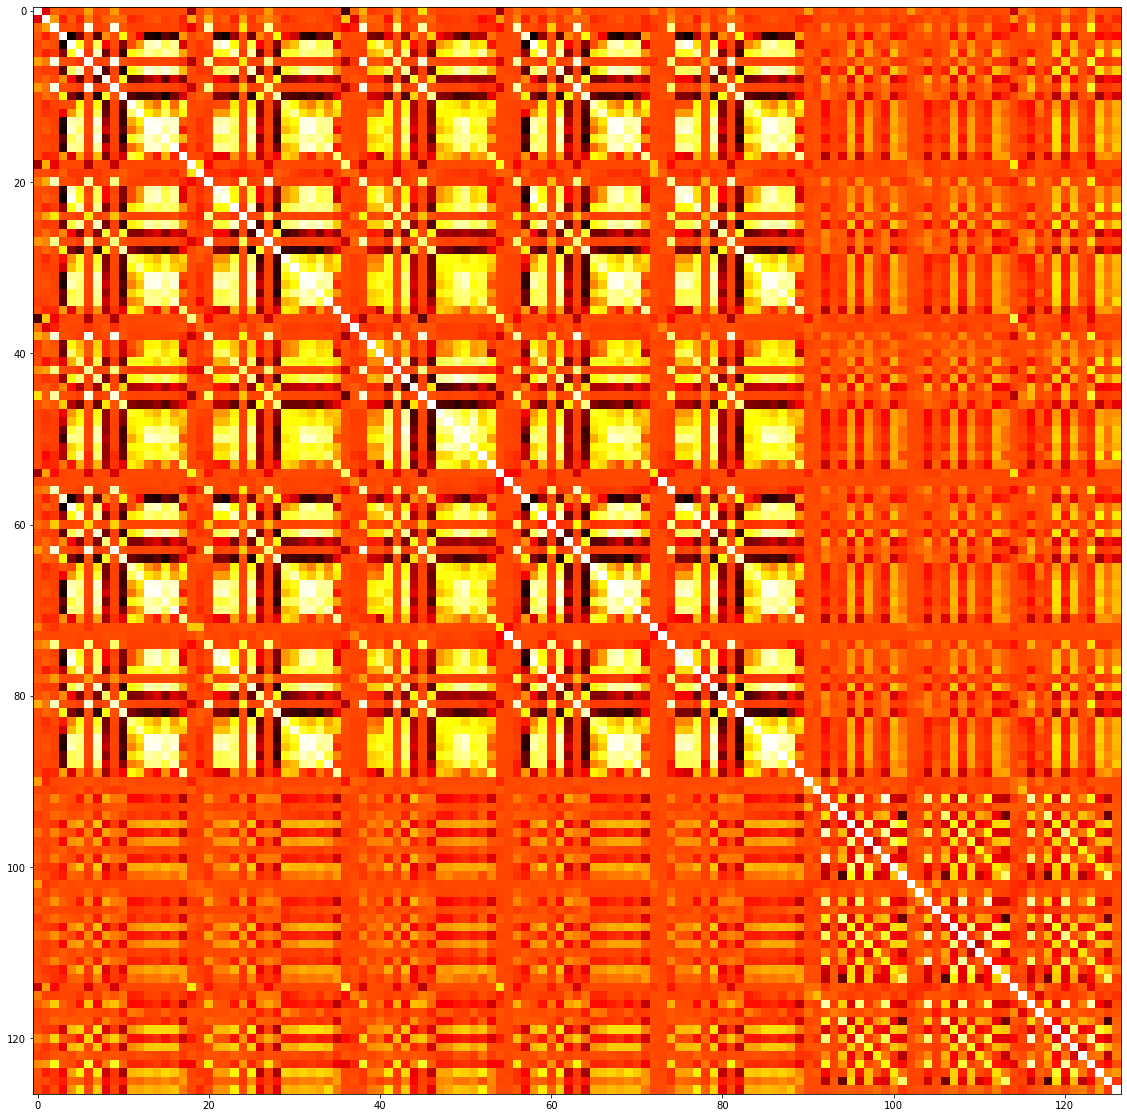

In [100]:
plt.figure(figsize = (20,20))
plt.imshow(corr_matrix,cmap='hot',interpolation='nearest')

In [285]:
X_train2 = X_train.iloc[:,0:24]
for i in range(1, 5):
    X_train2 = pd.concat([X_train2, X_train.iloc[:, 24*i:24*i+8]], axis = 1)
    X_train2 = pd.concat([X_train2, X_train.iloc[:, 24*i+9:24*i+11]], axis = 1)
    X_train2 = pd.concat([X_train2, X_train.iloc[:, 24*i+13]], axis = 1)
    X_train2 = pd.concat([X_train2, X_train.iloc[:, 24*i+15:24*i+22]], axis = 1)
    X_train2 = pd.concat([X_train2, X_train.iloc[:, 24*i+23]], axis = 1)
X_train2 = pd.concat([X_train2, X_train.iloc[:, 120:139]], axis = 1)
print(X_train2.shape)

(4450, 119)


In [286]:
X_test2 = X_test.iloc[:,0:24]
for i in range(1, 5):
    X_test2 = pd.concat([X_test2, X_test.iloc[:, 24*i:24*i+8]], axis = 1)
    X_test2 = pd.concat([X_test2, X_test.iloc[:, 24*i+9:24*i+11]], axis = 1)
    X_test2 = pd.concat([X_test2, X_test.iloc[:, 24*i+13]], axis = 1)
    X_test2 = pd.concat([X_test2, X_test.iloc[:, 24*i+15:24*i+22]], axis = 1)
    X_test2 = pd.concat([X_test2, X_test.iloc[:, 24*i+23]], axis = 1)
X_test2 = pd.concat([X_test2, X_test.iloc[:, 120:139]], axis = 1)
print(X_test2.shape)

(1725, 119)


In [277]:
X_tot2 = X_tot.iloc[:,0:24]
for i in range(1, 5):
    X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 24*i:24*i+8]], axis = 1)
    X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 24*i+9:24*i+11]], axis = 1)
    X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 24*i+13]], axis = 1)
    X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 24*i+15:24*i+22]], axis = 1)
    X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 24*i+23]], axis = 1)
X_tot2 = pd.concat([X_tot2, X_tot.iloc[:, 120:139]], axis = 1)
print(X_tot2.shape)

(6175, 119)


In [71]:
clf = XGBClassifier()

clf.fit(X_train, y_train)
train_predictions = clf.predict(X_test)
mf = f1_score(y_test, train_predictions,average ='macro')
print('macro_f1: {:.2%}'.format(mf))

macro_f1: 67.87%


In [94]:
clf = XGBClassifier(n_estimators = 200, max_depth = 2, learning_rate = 0.2, subsample=0.6, colsample_bytree=0.8, colsample_bylevel=0.7)

clf.fit(X_tot, y_tot)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [92]:
parameters = { 'n_estimators': [200, 500, 700, 800, 900, 1000, 1500]}

In [90]:
Rd_grid_search = RandomizedSearchCV(estimator=clf,
                        param_distributions=parameters,
                        scoring='f1_macro',
                        n_iter=15,
                        cv = 4,
                        verbose=1)

Rd_grid_search.fit(X_tot, y_tot)

print("Best parameters:", Rd_grid_search.best_params_)
print("Lowest f1_score: ", Rd_grid_search.best_score_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best parameters: {'max_depth': 2, 'learning_rate': 0.2}
Lowest f1_score:  0.6859606822994955


In [93]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring="f1_macro",
    n_jobs = 10,
    cv = 4,
    verbose=True
)

grid_search.fit(X_tot, y_tot)

print("Best parameters:", grid_search.best_params_)
print("Lowest f1_score: ", grid_search.best_score_)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best parameters: {'n_estimators': 200}
Lowest f1_score:  0.6849480264884975


In [95]:
predictions = []

test_records_list = list(test_data_for_records)

for record in test_records_list:
    record_number = int(record[-5])
    X_sub = test_data_for_records[record]
    
    print(X_sub.shape)

    preds = clf.predict(X_sub)
    for i, pred in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred})

predictions = pd.DataFrame(predictions)
print(predictions)

(936, 127)
(847, 127)
(863, 127)
      identifier  target
0          70000       0
1          70001       0
2          70002       0
3          70003       0
4          70004       0
...          ...     ...
2641       90858       4
2642       90859       4
2643       90860       2
2644       90861       0
2645       90862       0

[2646 rows x 2 columns]


In [96]:
predictions.to_csv('submissionXGBC10.csv',index = None)

In [97]:
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [98]:
# logging for visual comparison
for clf_try in classifiers:
    clf_try.fit(X_train, y_train)
    name = clf_try.__class__.__name__
    print("-"*27)
    print(name)
    print('----------Results----------')
    train_predictions = clf_try.predict(X_test)
    mf = f1_score(y_test, train_predictions,average ='macro')
    print('macro_f1: {:.2%}'.format(mf))

---------------------------
KNeighborsClassifier
----------Results----------
macro_f1: 31.33%
---------------------------
DecisionTreeClassifier
----------Results----------
macro_f1: 52.46%
---------------------------
RandomForestClassifier
----------Results----------
macro_f1: 53.18%
---------------------------
XGBClassifier
----------Results----------
macro_f1: 67.87%
---------------------------
AdaBoostClassifier
----------Results----------
macro_f1: 58.93%
---------------------------
GradientBoostingClassifier
----------Results----------
macro_f1: 64.36%
---------------------------
GaussianNB
----------Results----------
macro_f1: 18.14%
---------------------------
LinearDiscriminantAnalysis
----------Results----------
macro_f1: 51.72%
---------------------------
QuadraticDiscriminantAnalysis
----------Results----------
macro_f1: 29.23%


In [102]:
from scipy import signal

In [105]:
soseeg = signal.butter(10, [0.5, 50], 'bandpass', fs=250, output='sos')
sosacc = signal.butter(10, 0.1, 'hp', fs=50, output='sos')

In [108]:
a = np.load(f'training_records/record_2.npy')
x = a[0, 1:7501]
filtered = signal.sosfilt(soseeg, x)
print(len(filtered))

7500


In [109]:
def feat_extract_filt(file_name, records):
    data_for_records = {}
    hypnogram_for_records = {}
    hypnograms = pd.read_csv('targets_train.csv')
    for record in records :
        record_number = int(record[-5])
        data_for_record = np.load(f'{file_name}/{record}')
        for epoch in range (data_for_record.shape[0]):
            res = []
            for i in range(5):              
                data_record = data_for_record[epoch, 7500*i+1:7500*(i+1)+1]
                data_record = signal.sosfilt(soseeg, data_record)
                stat = wrapper(data_record)
                res.extend(stat)
            for t in range(3):
                data_record = data_for_record[epoch, 1500*t+37501:1500*(t+1)+37501]
                data_record = signal.sosfilt(sosacc, data_record)
                stat = wrapper3(data_record)
                res.extend(stat)
            res.append(epoch/data_for_record.shape[0])
            if epoch == 0 :
                res = [res]
                data_for_records[record] = pd.DataFrame(res)
            else :
                data_for_records[record].loc[epoch] = res
            if epoch%100 ==0:
                print(epoch)
        
        hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])
    return data_for_records, hypnogram_for_records

In [110]:
def test_feat_extract_filt(file_name, records):
    data_for_records = {}
    for record in records :
        record_number = int(record[-5])
        data_for_record = np.load(f'{file_name}/{record}')
        for epoch in range (data_for_record.shape[0]):
            res = []
            for i in range(5):              
                data_record = data_for_record[epoch, 7500*i+1:7500*(i+1)+1]
                data_record = signal.sosfilt(soseeg, data_record)
                stat = wrapper(data_record)
                res.extend(stat)
            for t in range(3):
                data_record = data_for_record[epoch, 1500*t+37501:1500*(t+1)+37501]
                data_record = signal.sosfilt(sosacc, data_record)
                stat = wrapper3(data_record)
                res.extend(stat)
            res.append(epoch/data_for_record.shape[0])
            if epoch == 0 :
                res = [res]
                data_for_records[record] = pd.DataFrame(res)
            else :
                data_for_records[record].loc[epoch] = res
            if epoch%100 ==0:
                print(epoch)

    return data_for_records

In [112]:
data_for_records2, hypnogram_for_records2 = feat_extract_filt("training_records", records_list)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
900


In [113]:
test_data_for_records2 = test_feat_extract_filt("test_records", test_records_list)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


In [114]:
train = []
y_train2 = []
for record in training_record :
    train.append(data_for_records2[record])
    y_train2.extend(hypnogram_for_records2[record])
    
X_train2 = pd.concat(train)
print(X_train2.shape)
print(len(y_train2))

(4450, 127)
4450


In [115]:
test = []
y_test2 = []
for record in test_records :
    test.append(data_for_records2[record])
    y_test2.extend(hypnogram_for_records2[record])
    
X_test2 = pd.concat(test)
print(X_test2.shape)
print(len(y_test2))

(1725, 127)
1725


In [116]:
clf2 = XGBClassifier()

clf2.fit(X_train2, y_train2)
train_predictions = clf2.predict(X_test2)
mf = f1_score(y_test2, train_predictions,average ='macro')
print('macro_f1: {:.2%}'.format(mf))

macro_f1: 63.96%
